**Colin Casazza**

**November 4, 2019**

**SDSU CS556**

**Assignment 3, Problem 2**

The purpose of this problem is to determine the inverse kinematics of a manipulator with the method of Decomposition and Approximation

In [1]:
## packages
import math
import random
import matplotlib
import tinyik
import numpy as np
import sympy as sp
import pandas as pd
from sympy.solvers import solve
from sympy.physics.mechanics import dynamicsymbols
from sympy.physics.vector import init_vprinting
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

# configure pretty latex like printing
init_vprinting(use_latex='mathjax', pretty_print=False)

# number of random input angles
# to fuzz into the forward kinematics
# equations for approximation
NUMBER_TRIALS = 5000

# link lengths (in centimeters)
L1_LENGTH = 100
L2_LENGTH = 100

# the resolution for our 
# our grid space approximation
NUMBER_ROWS = 40
NUMBER_COLS = 40

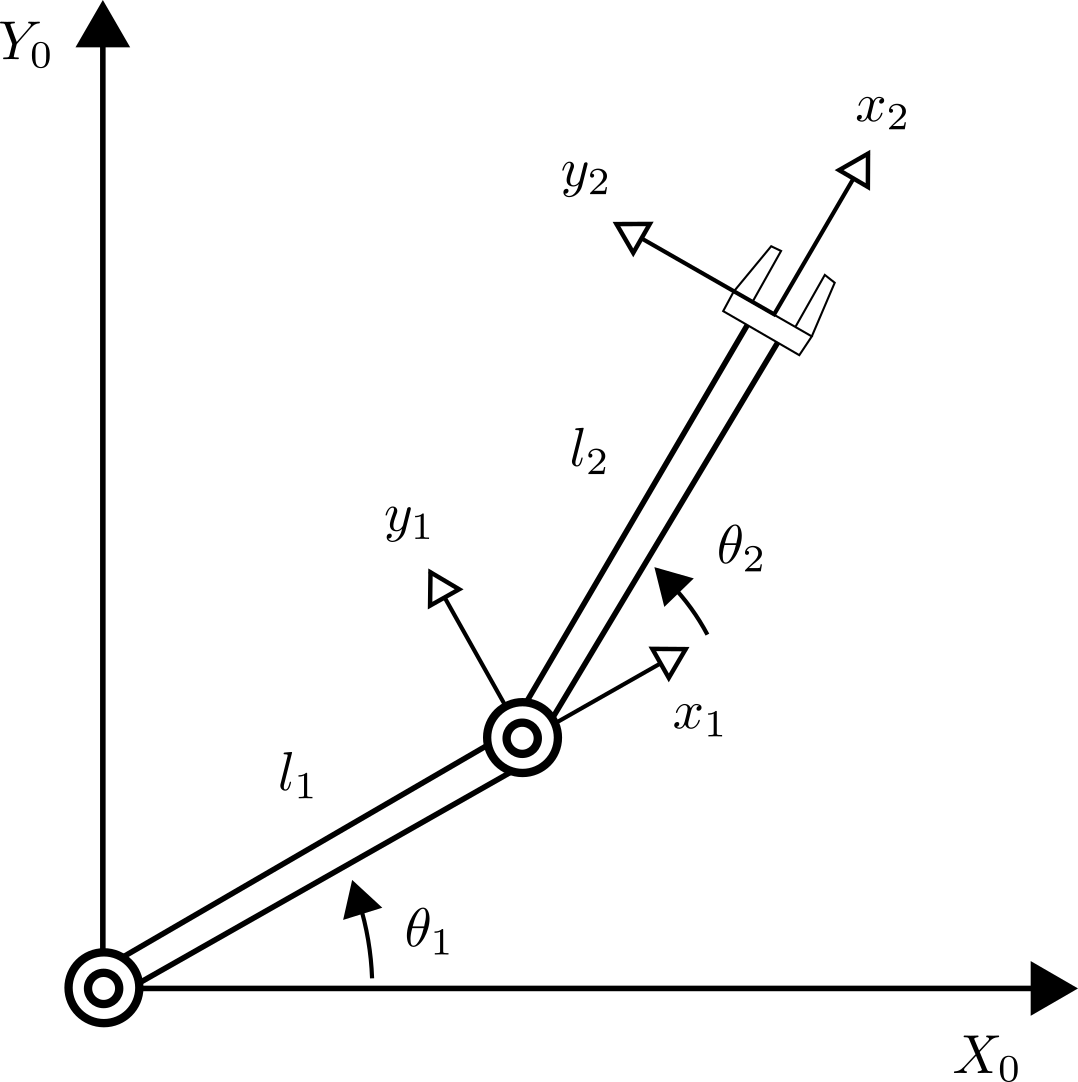

In [2]:
"""
Derive the forward kinematics equations to find the 
corresponding x,y coordnates based on given (θ1, θ2) 
pair for the 2PR manipulator
"""

# here's an image of the robot arm in question
from IPython.display import Image
Image('fig/img1.png', width=300)

In [3]:
# declare the symbolic variables
# we'll need to do linear algebra
theta1, theta2, l1, l2, theta, alpha, a, d = \
    dynamicsymbols('theta1 theta2 l1 l2 theta alpha a d')

# show the symbolic variables we've made
theta1, theta2, l1, l2, theta, alpha, a, d

(theta1, theta2, l1, l2, theta, alpha, a, d)

In [4]:
# rotation matrix based off
# of our dh table
rotation_matrix = sp.Matrix(
    [
        [
            sp.cos(theta), 
            -sp.sin(theta) * sp.cos(alpha),
            sp.sin(theta) * sp.sin(alpha)
        ], [
            sp.sin(theta),
            sp.cos(theta) * sp.cos(alpha), 
            -sp.cos(theta) * sp.sin(alpha)
        ], [
            0, 
            sp.sin(alpha), 
            sp.cos(alpha)
        ]
    ]
)

# x,y,z transformation matrix
transformation_matrix = sp.Matrix(
    [a * sp.cos(theta), a * sp.sin(theta), d]
)

# the definition for the last row
# in a homogenous transformation matrix
last_row = sp.Matrix([[0, 0, 0, 1]])

# combine the rotation, transformation and last row
# to get homogenous transformation matrix
t = sp.Matrix.vstack(
    sp.Matrix.hstack(rotation_matrix, transformation_matrix), 
    last_row
)

# show the homogenous transformation matrix
display(t)

Matrix([
[cos(theta), -sin(theta)*cos(alpha),  sin(alpha)*sin(theta), a*cos(theta)],
[sin(theta),  cos(alpha)*cos(theta), -sin(alpha)*cos(theta), a*sin(theta)],
[         0,             sin(alpha),             cos(alpha),            d],
[         0,                      0,                      0,            1]])

In [5]:
# given the homogenous transformation matrix
# we need to find the transformation from 
# frame 0 to frame 2
t_02 = (
    t.subs({alpha:0, a:l1, theta:theta1, d:0}) * 
    t.subs({alpha:0, a:l2, theta:theta2, d:0})
)

t_02.simplify()

# show the transformation_matrix
# for 0 to 2
display(t_02)

Matrix([
[cos(theta1 + theta2), -sin(theta1 + theta2), 0, l1*cos(theta1) + l2*cos(theta1 + theta2)],
[sin(theta1 + theta2),  cos(theta1 + theta2), 0, l1*sin(theta1) + l2*sin(theta1 + theta2)],
[                   0,                     0, 1,                                        0],
[                   0,                     0, 0,                                        1]])

In [6]:
# give our transformation matrix
# we can derive forward kinematics
# for example
x_position = t_02[0,3]
y_position = t_02[1,3]

# show the functions for
# x and y positions
display(x_position)
display(y_position)

l1*cos(theta1) + l2*cos(theta1 + theta2)

l1*sin(theta1) + l2*sin(theta1 + theta2)

In [7]:
# using sympy's lambdify function 
# we can turn the forward kinematic
# equations into standard functions
fx = sp.lambdify((l1, l2, theta1, theta2), x_position, 'numpy')
fy = sp.lambdify((l1, l2, theta1, theta2), y_position, 'numpy')
# def rr_fk(l1, l2, theta1, theta2):
#     return (
#         l1*math.cos(theta1) + l2*math.cos(theta1 + theta2),
#         l1*math.sin(theta1) + l2*math.cos(theta1 + theta2)
#     )

# function to get inverse kinematics
# using algebraic solution

def rr_ik(x,y):

    # positive solution
    a = (x**2 + y**2 - L1_LENGTH**2 -L2_LENGTH**2)
    b = (2 * L1_LENGTH * L2_LENGTH)
    t2 = math.acos((a/b))
    t1p = (
        math.atan2(y,x) - math.atan2(L1_LENGTH*math.sin(t2), L1_LENGTH+L2_LENGTH*math.cos(t2))
    )
    t1n = (
        math.atan2(y,x) - math.atan2(L1_LENGTH*math.sin(-t2), L1_LENGTH+L2_LENGTH*math.cos(-t2))
    )

    return[(t1p, t2), (t1n, -t2)]
    
# def rr_ik(x,y):

#     # positive solution
#     a = ((x**2 + y**2) - (L1_LENGTH**2 + L2_LENGTH**2))
#     b = (2 * L1_LENGTH * L2_LENGTH)
#     t2p = math.acos((a/b))
#     t1p = math.atan(
#         (
#             (-L2_LENGTH*math.sin(t2p) * x  + (L1_LENGTH+L2_LENGTH*math.cos(t2p))*y)
#                 /
#             (L2_LENGTH*math.sin(t2p) * y  + (L1_LENGTH+L2_LENGTH*math.cos(t2p))*x)
#         )
#     )

#     # negative solution
#     t2n = t2p * -1.0
#     t1n = math.atan(
#         (
#             (-L2_LENGTH*math.sin(t2n) * x  + (L1_LENGTH+L2_LENGTH*math.cos(t2n))*y)
#                 /
#             (L2_LENGTH*math.sin(t2n) * y  + (L1_LENGTH+L2_LENGTH*math.cos(t2n))*x)
#         )
#     )

#     return[(t1p, t2p), (t1n, t2n)]
    
for i in range(10):
    t1 = np.deg2rad(random.uniform(0,170))
    t2 = np.deg2rad(random.uniform(-90,90))
    print('----')
    print((t1,t2))
    fk = (
        fx(L1_LENGTH, L2_LENGTH, t1, t2),
        fy(L1_LENGTH, L2_LENGTH, t1, t2) 
    )
    ik = rr_ik(fk[0],fk[1])
    print(ik[0])
    print(ik[1])

----
(0.897300535291158, 0.3067775191091439)
(0.8973005352911579, 0.30677751910914425)
(1.2040780544003022, -0.30677751910914425)
----
(2.4428531065795127, -1.2012209331176826)
(1.2416321734618303, 1.2012209331176822)
(2.4428531065795123, -1.2012209331176822)
----
(2.5992517200095255, -0.14182933177503862)
(2.457422388234488, 0.14182933177503743)
(2.599251720009525, -0.14182933177503743)
----
(2.223981408921261, -0.47189118668345736)
(1.7520902222378036, 0.4718911866834577)
(2.223981408921261, -0.4718911866834577)
----
(2.16977486525367, 1.200138799177954)
(2.1697748652536695, 1.2001387991779544)
(3.3699136644316243, -1.2001387991779544)
----
(1.7411425650015453, -0.27333831021547805)
(1.4678042547860664, 0.27333831021547966)
(1.7411425650015462, -0.27333831021547966)
----
(0.6684878862682736, -0.6186126102227478)
(0.04987527604552566, 0.6186126102227484)
(0.6684878862682739, -0.6186126102227484)
----
(2.6373844246247202, 1.5177576854502397)
(-3.6458008825548665, 1.51775768545024)
(-2.

In [8]:
"""
Generate some 5000 (more if you need) random (θ1, θ2) pairs, 
and  use the forward kinematics equations to find the 
corresponding  points in workspace. Keeps a record of 
points in each cell.
"""

# now we can choose random inputs
# fuzz the output position
# first generate random angle inputs
# for theta1 and theta2
inputs = [
    (
        np.deg2rad(random.uniform(0,170)),
        np.deg2rad(random.uniform(-90,90))
    ) for x in range(NUMBER_TRIALS)
]

# map the forward kinematics 
# equations onto the input set
outputs = [
    {
        "angles": (i[0], i[1]),
        "fk": (
            fx(L1_LENGTH, L2_LENGTH, i[0], i[1]),
            fy(L1_LENGTH, L2_LENGTH, i[0], i[1]) 
        )
    } for i in inputs
]

In [9]:
# plot the fuzzed forward
# kinematics to show our workspace
x_cord = list(map(lambda e: e['fk'][0], outputs))
y_cord = list(map(lambda e: e['fk'][1], outputs))
fig = px.scatter(x=x_cord, y=y_cord)
fig.show()

# helper variables for
# our workspace frame
x_min = math.floor(min(x_cord))
y_min = math.floor(min(y_cord))
x_max = math.ceil(max(x_cord))
y_max = math.ceil(max(y_cord))
workspace_width = x_max - x_min
workspace_height = y_max - y_min

In [10]:
"""
Divide the joint and workspace in into square cells. 

You will need to decide on the size of the cells in the 
joint space and work space, for example x=y=10 cm.
"""

# helper variables for our
# grid representation
cell_width = workspace_width / NUMBER_COLS
grid_width = math.ceil(workspace_width / cell_width)
cell_height = workspace_height / NUMBER_ROWS
grid_height = math.ceil(workspace_height / cell_height)

def get_grid_coordinates(x,y):
    _x = math.floor(((x - x_min) / workspace_width ) * grid_width)
    _y = math.floor(((y - y_min) / workspace_height) * grid_height)
    return _x,_y

# first set up a grid of points
# so we can determine how to group
# results from forward kinematics
grid_points = [
    [
        [] for x in range(grid_width)
    ] for y in range(grid_height)
]

# for each generated forward kinematics
# output coordinate, we need to find it's
# position in the grid and put in the grid
# array we made previously
for output in outputs:    
    x_cord,y_cord = get_grid_coordinates(
        output['fk'][0],
        output['fk'][1]
    )
    grid_points[y_cord][x_cord].append({
        "angles": (
            output['angles'][0], 
            output['angles'][1]
        ), 
        "fk": (
            output['fk'][0], 
            output['fk'][1]
        )
    })

In [11]:
# some helper objects for the chart
# we're about to make, dictionary of
# colors we can randomly select from
hex_colors_dic = {}
rgb_colors_dic = {}
hex_colors_only = []

for name, hex in matplotlib.colors.cnames.items():
    hex_colors_only.append(hex)
    hex_colors_dic[name] = hex
    rgb_colors_dic[name] = matplotlib.colors.to_rgb(hex)

# now plot each grid as an individual
# trace in the scatter plot
grid_plot = go.Figure()
theta_plot = go.Figure()
for y_index, row in enumerate(grid_points):
    for x_index, col in enumerate(row):
        if(len(col) == 0): continue
        x=list(map(lambda x: x['fk'][0], col))
        y=list(map(lambda y: y['fk'][1], col))
        tx=list(map(lambda x: x['angles'][0], col))
        ty=list(map(lambda y: y['angles'][1], col))
        color = random.choice(hex_colors_only)
        grid_plot.add_trace(
            go.Scatter(
                x=x, 
                y=y,
                mode='markers',
                fillcolor=color,
                name='(' + str(x_index) + ',' + str(y_index) + ')'
            )
        )
        theta_plot.add_trace(
            go.Scatter(
                x=tx, 
                y=ty,
                mode='markers',
                fillcolor=color,
                name='(' + str(x_index) + ',' + str(y_index) + ')'
            )
        )
# show the plots
grid_plot.show()
theta_plot.show()

In [12]:
"""
Using k-mean clustering, divide the points 
in each cell into two clusters, representing  
the two solutions.
"""

# now lets turn the output grid 
# into a data frame for easier 
# analysis of our approximation
grid_df = pd.DataFrame(
    e for e in grid_points
)

# helper function to find
# k_means clusters for each
# cell of the dataframe
# and split coordinates in cell
# into groups based on k_means cluster
def k_means_split(cell):
    if len(cell) < 3: return None

    x = list(map(lambda e: e['fk'][0], cell))
    y = list(map(lambda e: e['fk'][1], cell))
    df = list(zip(x,y))

    kmeans = KMeans(n_clusters=2, random_state=0)
    cluster_indexes = kmeans.fit_predict(df)
    return [
        [e for i,e in enumerate(cell) if cluster_indexes[i] == 0],
        [e for i,e in enumerate(cell) if cluster_indexes[i] == 1]
    ]

# apply the function to split
# each cell into two clusters
cluster_grid_df = grid_df.applymap(k_means_split)

In [13]:
"""
In each cell and each cluster in the cell, 
approximate the inverse kinematics by 
linear relationship of the form

x=ai 1+bi2+ci; x=di 1+ei2+fi; 

where i=1,2, ..., n are the cell numbers, 
and the coefficients ai to fi are found 
using regression (curve fitting).

Store the coefficients. This completes 
the decomposition and approximation.
"""

# now that we have our grid of
# clustered cells, we can do a
# linear regression on each
# cluster in all the cells

def lin_reg(cell):
    # if there aren't any points 
    # in the cell, do nothing
    if cell == None:
        return None
    
    # for each cluster in the cell
    # do a linear regression for the 
    # cluster's set of points
    new_cell = []
    for cluster in cell:
        
        x_coordinates = list(map(lambda e: e['fk'][0], cluster))
        y_coordinates = list(map(lambda e: e['fk'][1], cluster))
        x_y_pairs = list(zip(x_coordinates, y_coordinates))
        
        # linear regression for theta1
        theta1_dependent = list(map(lambda e: e['angles'][0], cluster))
        
        # linear regression for theta2
        theta2_dependent = list(map(lambda e: e['angles'][1], cluster))
        new_cell.append({
            "theta1": 
                LinearRegression().fit(
                    x_y_pairs, 
                    theta1_dependent
                ),
            "theta2": 
                LinearRegression().fit(
                    x_y_pairs, 
                    theta2_dependent
                ) 
        })
    return new_cell

lin_reg_cluster_grid = cluster_grid_df.applymap(lin_reg)

In [16]:
"""
Given a set of 100 position (x,y) points find the corresponding two solution (θ1, θ2) pairs for each position.
"""
# helper for finding closed
# for inverse kinematics
arm = tinyik.Actuator([
    'z', [L1_LENGTH, 0., 0.], 
    'z', [L2_LENGTH, 0., 0.]
])

# create an array of (x,y) pairs to test
# inverse kinematics on
test_points = [
    (
        np.deg2rad(random.uniform(0,170)),
        np.deg2rad(random.uniform(-90,90))
    ) for x in range(10)
]
print(test_points)

for point in test_points:
    # get the grid coordinates
    # for the regression lookup
    x,y = get_grid_coordinates(point[0], point[1])
    
    # don't do anything if there's nothing in the cell
    if(lin_reg_cluster_grid[x][y] is None): continue
        
    # get the inverse kinematic solutions
    # based of the cluster linear regressions
    c1, c2 = lin_reg_cluster_grid[x][y]
    
    s1_t1 = c1['theta1'].predict([[point[0], point[1]]])[0]
    s1_t2 = c1['theta2'].predict([[point[0], point[1]]])[0]
    s2_t1 = c2['theta1'].predict([[point[0], point[1]]])[0]
    s2_t2 = c2['theta2'].predict([[point[0], point[1]]])[0]
    
    ik = rr_ik(point[0], point[1]) or [(None,None),(None,None)] 
#     # get inverse kinematics
#     # for verification
#     arm.ee = [point[0], point[1], 0]
#     ik = arm.angles
    print("--------------------")
    print("p:   ", point)
    print("s1:  ", (s1_t1, s1_t2))
    print("s2:  ", (s2_t1, s2_t2))
    print("ik1: ", ik[0])
    print("ik2: ", ik[1])